# Задание Aviasales

## 1 часть

Чтобы выявить причину в расхождении общих сумм, необходимо рассмотреть 3 момента:

1.   Корректность сохранения данных партнера в базу
2.   Корректность самих данных партнера
3.   Убедиться, что партнер отразил в отчете корректные данные



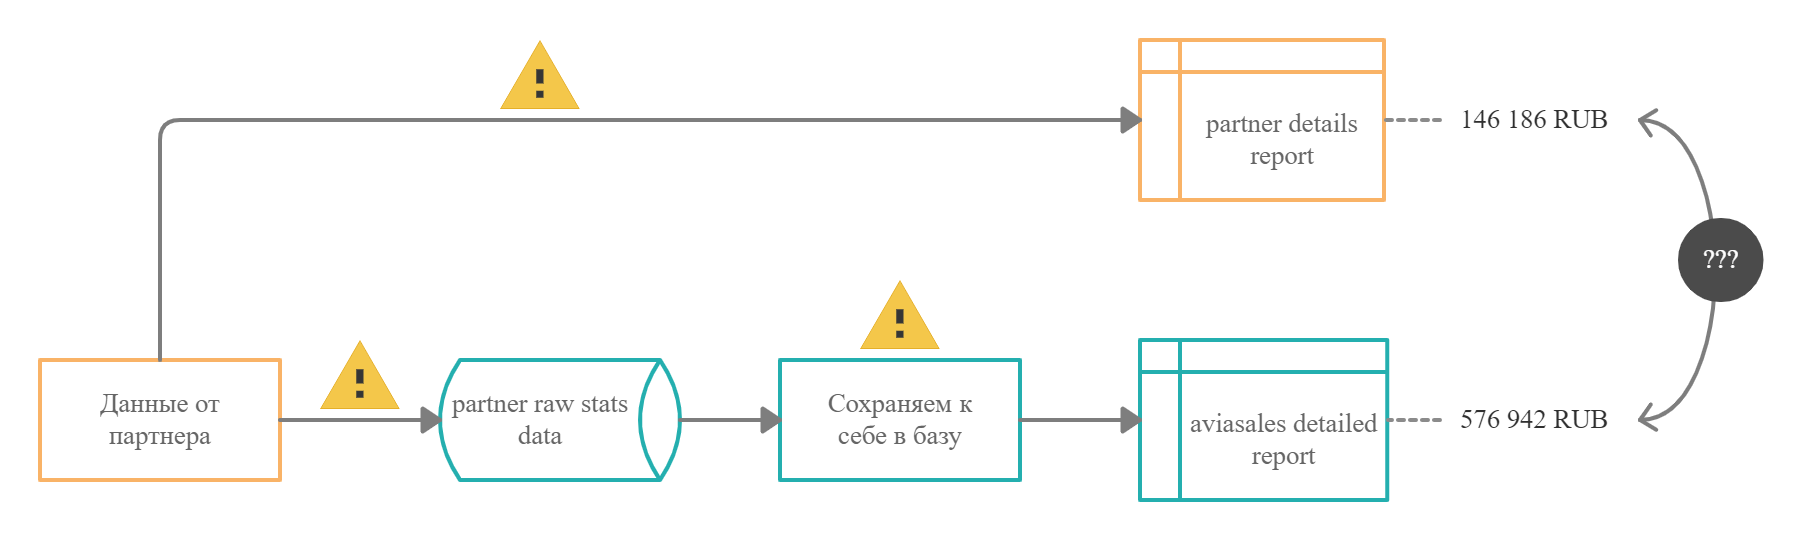

In [40]:
# Импорт библиотек

import pandas as pd
import numpy as np

In [41]:
# Импорт данных

aviasales_det_report = pd.read_excel('aviasales detailed report.xlsx', skipfooter=1, dtype={'OrderNumber': 'int',
                                                                                                'Price': 'int',
                                                                                                'Proposal_price': 'int',
                                                                                                'Profit': 'int'})
partner_det_report = pd.read_excel('partner details report.xlsx', header=1, usecols='A:C,E,F', skipfooter=1, dtype={'OrderID': 'int',
                                                                                                                             'Value': 'int'})
partner_raw_stats = pd.read_excel('partner raw stats data.xlsx', dtype={'orderid': 'int',
                                                                                   'price': 'int'})

Проверим правильно ли сохраняются данные, полученные от партнёра, в “aviasales detailed report”.

In [42]:
# Взглянем структуру данных. Сразу видим, что есть дубликаты по orderid

partner_raw_stats.head()

,created_at,orderid,ouid,price,type
0,2017-11-01 00:15:39.851,4998262003,1a1tfs6ib5,17420,DOM
1,2017-11-01 00:17:20.161,4998262003,1a1tfs6ib5,17420,DOM
2,2017-11-01 00:21:26.259,4998262003,1a1tfs6ib5,17420,DOM
3,2017-11-01 00:23:26.366,4998262003,1a1tfs6ib5,17420,DOM
4,2017-11-01 00:29:38.342,4998336321,1a1twfwfg6,5620,DOM


Рассчитаем сумму комиссии по “partner raw stats data” и сравним ее с суммой комиссии по “aviasales detailed report”.

In [43]:
# Рассчитаем комиссию по данным полученным от партнера

partner_raw_stats.insert(5, 'profit', 0)
for id in np.unique(partner_raw_stats.orderid):
  if (partner_raw_stats[partner_raw_stats.orderid == id].type == 'DOM').values[0]:
    partner_raw_stats.loc[partner_raw_stats.orderid == id, 'profit'] = 40
  elif (partner_raw_stats[partner_raw_stats.orderid == id].type == 'INT').values[0]:
    partner_raw_stats.loc[partner_raw_stats.orderid == id, 'profit'] = round(partner_raw_stats[partner_raw_stats.orderid == id].price / 100 * 1.5).values[0]

partner_raw_stats = partner_raw_stats.astype({'profit': 'int'}, copy=True)
partner_raw_stats.drop_duplicates(subset=['orderid'], inplace=True) # Выкидываем дубликаты

In [44]:
print('Рассчитанная комиссия:', partner_raw_stats.profit.sum(), 'INR', ' | ', 'Комиссия Aviasales:', aviasales_det_report.Profit.sum(), 'RUB')

Рассчитанная комиссия: 648316 INR  |  Комиссия Aviasales: 576937 RUB


Теперь сравним количество бронирований между двумя таблицами.

In [9]:
len(partner_raw_stats)

805

In [10]:
len(aviasales_det_report)

802

Рассчитанная комиссия примерно равна комиссии Aviasales. Однако у нас нет данных по трем бронированиям. Рассмотрим этот случай.

In [47]:
# Соединим две таблицы для сравнения
df3 = pd.merge(partner_raw_stats, aviasales_det_report, left_on='orderid', right_on='OrderNumber', how='outer', indicator=True)
df3.drop(['created_at', 'ouid', 'State', 'OrderNumber'], axis=1, inplace=True)
df3 = df3.reindex(columns=['orderid', 'Price', 'Proposal_price', 'price', 'Profit', 'profit', 'type', '_merge'])

In [49]:
df3[df3._merge == 'left_only']

,orderid,Price,Proposal_price,price,Profit,profit,type,_merge
7,5003829179,NaN,NaN,12440,NaN,40,DOM,left_only
795,5178927194,NaN,NaN,7800,NaN,40,DOM,left_only
796,5178975028,NaN,NaN,7200,NaN,40,DOM,left_only


Проверим наличие этих бронирований по всем трем таблицам.

In [50]:
for indx in list(df3[df3._merge == 'left_only'].orderid):
  print(f'Order {indx} in partner_raw_stats: {not partner_raw_stats[partner_raw_stats.orderid == indx].empty}')
  print(f'Order {indx} in partner_det_report: {not partner_det_report[partner_det_report.OrderID == indx].empty}')
  print(f'Order {indx} in aviasales_det_report: {not aviasales_det_report[aviasales_det_report.OrderNumber == indx].empty}')
  print('\n')

Order 5003829179 in partner_raw_stats: True
Order 5003829179 in partner_det_report: True
Order 5003829179 in aviasales_det_report: False


Order 5178927194 in partner_raw_stats: True
Order 5178927194 in partner_det_report: False
Order 5178927194 in aviasales_det_report: False


Order 5178975028 in partner_raw_stats: True
Order 5178975028 in partner_det_report: False
Order 5178975028 in aviasales_det_report: False




Только бронирование 5003829179 есть в отчете партнера.

Можем сделать вывод, что в целом, полученная от партнера статистика корректно сохраняется в базу Aviasales.

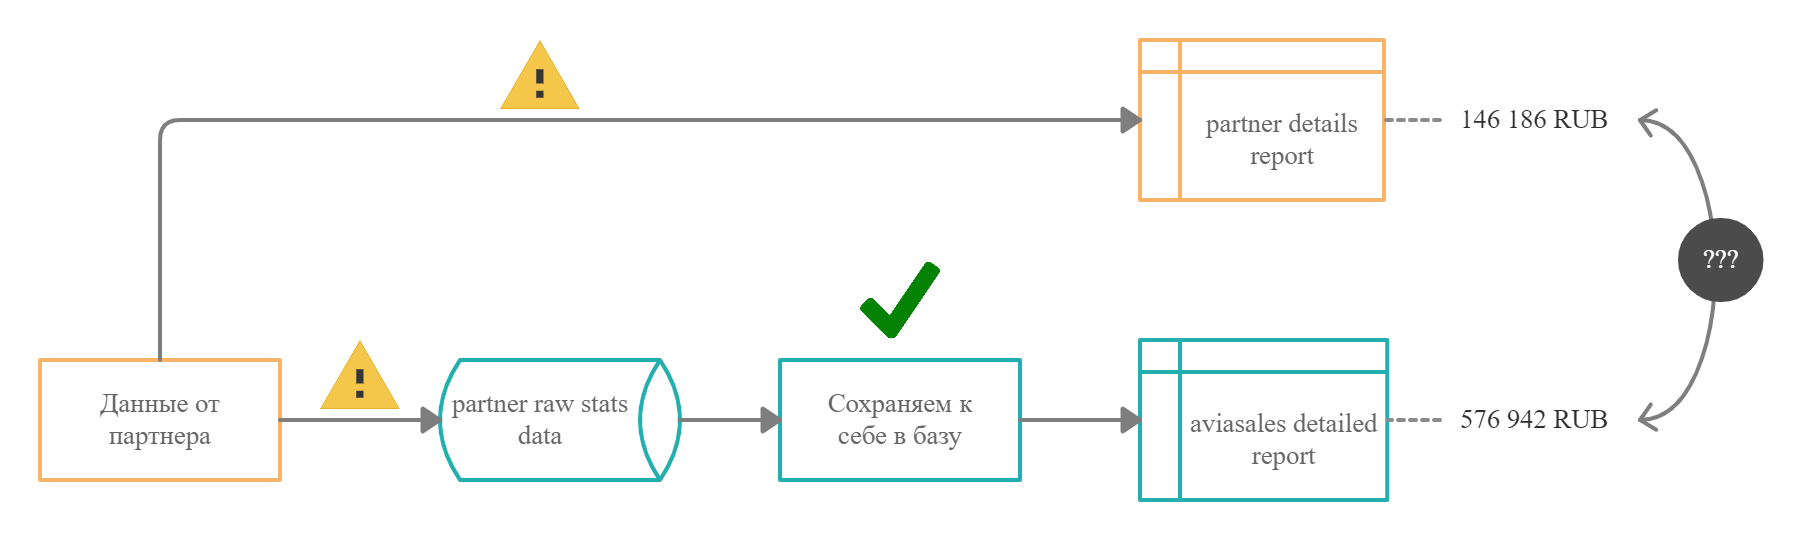

Теперь проверим корректно ли партнер присылает статистику. Сравним бронирования в “partner raw stats data” и “partner details report”.

Допустим за "ground truth" мы примем отчет партнера, то есть данные в “partner details report”.

In [54]:
# Соединим две таблицы для сравнения
df4 = pd.merge(partner_raw_stats, partner_det_report, left_on='orderid', right_on='OrderID', how='outer', indicator=True)
df4[df4._merge == 'right_only']

,created_at,orderid,ouid,price,type,profit,CompletedDate,OUID,OrderID,Value,OrderStatus,_merge
805,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,IntlIBUWAP_DBRT,4.169100e+09,-11290.0,R,right_only
806,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,IntlIBUWAP_DBRT,4.172497e+09,-11310.0,R,right_only
807,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,DomsIBUWAP_DBRT,4.296467e+09,-4320.0,R,right_only
808,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,DomsIBUWAP_DBRT,4.296502e+09,-12640.0,T,right_only
809,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,DomsIBUWAP_DBOW,4.306663e+09,-11420.0,R,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...
965,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,1ax1jzkvhy,5.171976e+09,6520.0,S,right_only
966,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,IntlIBUWAP_DBRT,5.175549e+09,3600.0,S,right_only
967,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,DomsIBUWAP_DBRT,5.177389e+09,55800.0,S,right_only
968,NaT,NaN,NaN,NaN,NaN,NaN,2017-11-01,DomsIBUWAP_DBRT,5.177393e+09,19260.0,S,right_only


Партнер передал не все данные. Есть 165 бронирований, которые присуствуют только в “partner details report”.

In [55]:
df4[df4._merge == 'left_only']

,created_at,orderid,ouid,price,type,profit,CompletedDate,OUID,OrderID,Value,OrderStatus,_merge
19,2017-11-01 17:26:30.108,5.010891e+09,1a2lgxajc7,30100.0,DOM,40.0,NaN,NaN,NaN,NaN,NaN,left_only
22,2017-11-01 19:51:11.462,5.011060e+09,1a2pr34hv2,0.0,DOM,40.0,NaN,NaN,NaN,NaN,NaN,left_only
24,2017-11-01 21:47:31.058,5.011143e+09,1a2szhxdso,0.0,INT,0.0,NaN,NaN,NaN,NaN,NaN,left_only
31,2017-11-02 06:23:25.621,5.016835e+09,1a37edu7yg,0.0,INT,0.0,NaN,NaN,NaN,NaN,NaN,left_only
38,2017-11-02 11:25:54.288,5.020872e+09,1a3fo9eqaz,13840.0,DOM,40.0,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...
800,2017-11-30 18:52:23.471,5.179116e+09,1aynelunhs,10210.0,INT,153.0,NaN,NaN,NaN,NaN,NaN,left_only
801,2017-11-30 19:24:16.595,5.179130e+09,1ayoa0nevr,18800.0,DOM,40.0,NaN,NaN,NaN,NaN,NaN,left_only
802,2017-11-30 19:31:32.083,5.179130e+09,1ayoapv4n5,8250.0,INT,124.0,NaN,NaN,NaN,NaN,NaN,left_only
803,2017-11-30 19:42:24.241,5.179135e+09,1aynkfzkht,100080.0,DOM,40.0,NaN,NaN,NaN,NaN,NaN,left_only


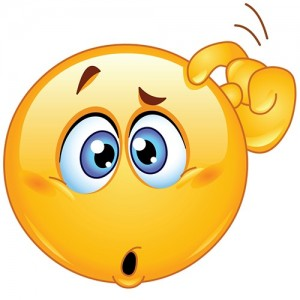

Но самое интересное, что в “partner raw stats data” есть 124 бронирования, которых нет в отчете партнера. Возможно, партнер отразил в своем отчете не все данные.

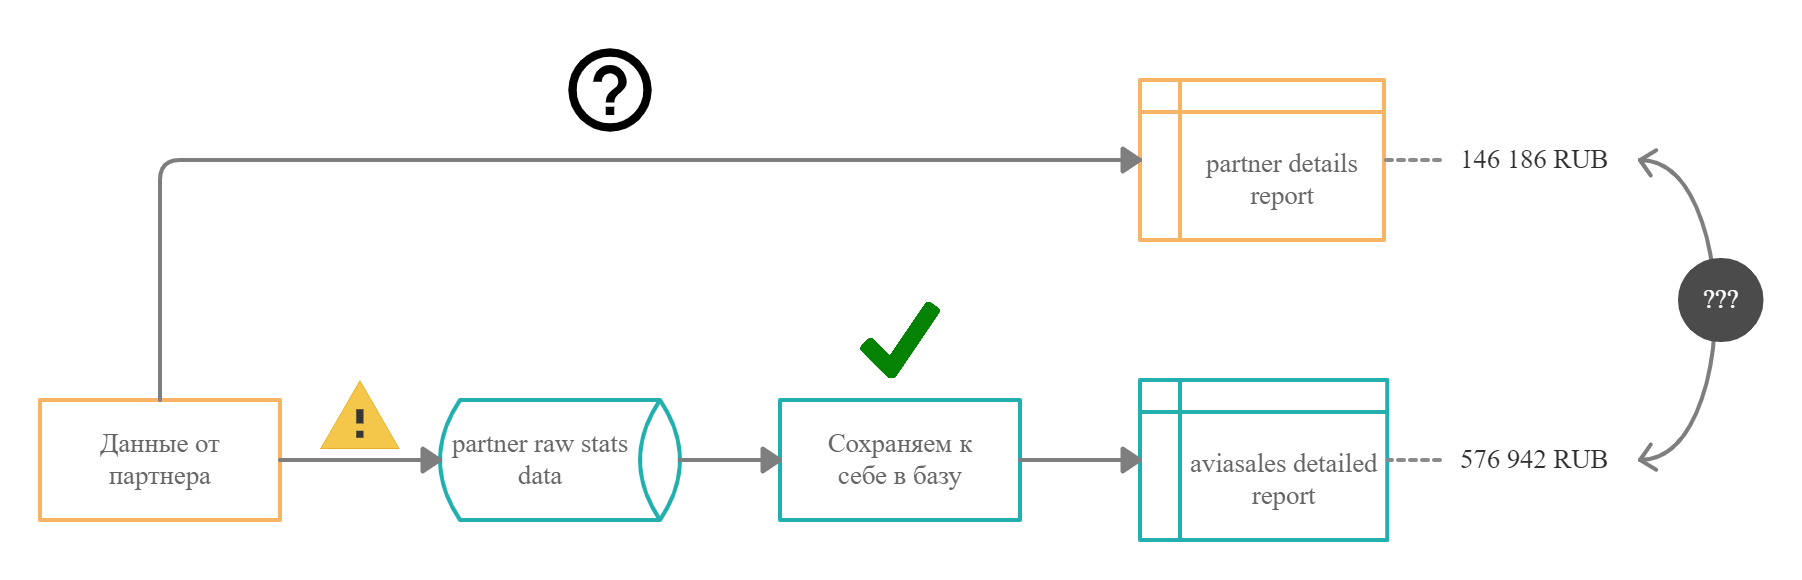

Сумма комиссий в отчете Aviasales в несколько раз больше чем в отчете партнера. Стоит проверить две суммы цен в “aviasales detailed report”.

In [56]:
aviasales_det_report.Price.sum()

48779519

In [57]:
aviasales_det_report.Proposal_price.sum()

15010539

Видим расхождение в суммах (Price, Proposal price) в 3 раза. Выведем бронирования, цены которых (Price и Proposal price) сильно отличаются.

In [63]:
aviasales_det_report[((aviasales_det_report.Price / aviasales_det_report.Proposal_price) >= 3) | ((aviasales_det_report.Proposal_price / aviasales_det_report.Price) >= 3)]

,OrderNumber,Price,Proposal_price,Profit,State
1,5179130338,7294,47132,109,paid
3,5179134875,88478,10169,35,paid
4,5179116497,9026,59614,135,paid
7,5178980603,69417,15308,1041,paid
8,5178920942,3101501,19011,46523,paid
...,...,...,...,...,...
790,5007771194,0,7569,35,paid
792,5004522192,0,38358,0,paid
797,5001073539,0,7475,35,paid
798,5000943338,0,12136,35,paid


Комиссия Aviasales рассчитывается по цене в столбце "Price". Можно заметить, что у некоторых бронирований цена по "Price" сильно завышена, из-за чего комиссия получается аномально большой. Например, бронирование 5144561627 в отчете партнера стоит 11 550 INR. В отчете Aviasales оно стоит 1 697 095 RUB. Также, есть бронирования, у которых цена по "Price" равна нулю, хотя по "Proposal price" цена верная. Например, бронирование 4999812139 в отчете партнера стоит 8 870 INR, а в отчете Aviasales 0 RUB. Это международный билет, и комиссия не фиксированная, а равна 1,5% от его стоимости.

In [61]:
partner_det_report[partner_det_report.OrderID == 5144561627]

,CompletedDate,OUID,OrderID,Value,OrderStatus
570,2017-11-01,IntlIBUWAP_DBOW,5144561627,11550,S


In [62]:
aviasales_det_report[aviasales_det_report.OrderNumber == 5144561627]

,OrderNumber,Price,Proposal_price,Profit,State
261,5144561627,1697095,10310,25456,paid


In [64]:
partner_det_report[partner_det_report.OrderID == 4999812139]

,CompletedDate,OUID,OrderID,Value,OrderStatus
26,2017-11-01,IntlIBUWAP_DBOW,4999812139,8870,S


In [65]:
aviasales_det_report[aviasales_det_report.OrderNumber == 4999812139]

,OrderNumber,Price,Proposal_price,Profit,State
799,4999812139,0,7817,0,paid


Можно сделать вывод, что **партнер некорректно присылал статистику, а также возможно предоставил не все данные по бронированиям в отчете.**

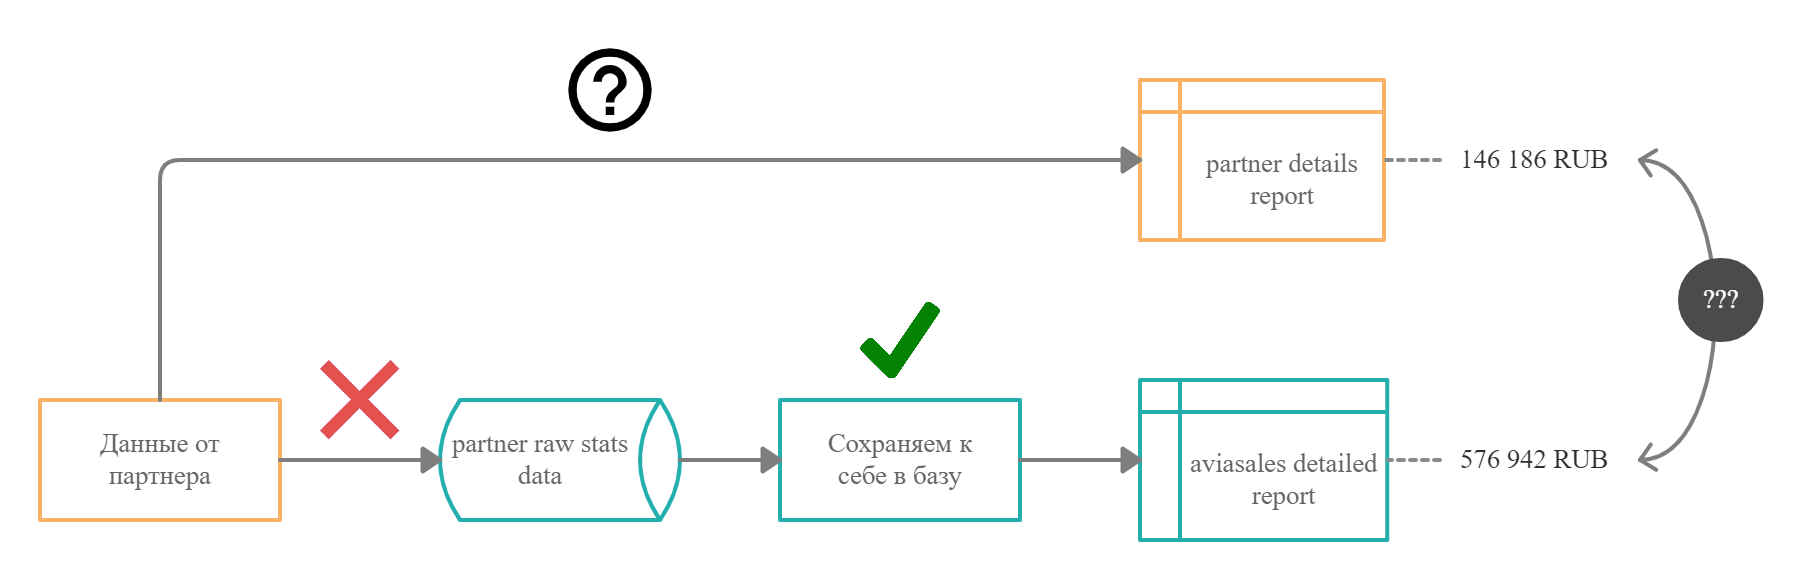

## 2 часть

Рассчитаем корректную комиссию для бронирований, записанных в статистику Aviasales.

Корректную цену в INR будем брать из отчета партнера. Если бронирования нет в отчете, то комиссия будет рассчитываться по "Proposal_price".

In [33]:
# Рассчитаем корректную комиссию

aviasales_det_report.insert(5, 'Correct profit (INR)', 0)
for id in list(aviasales_det_report.OrderNumber):
  if (partner_raw_stats[partner_raw_stats.orderid == id].type == 'DOM').values[0]:
    aviasales_det_report.loc[aviasales_det_report.OrderNumber == id, 'Correct profit (INR)'] = 40

  elif (partner_raw_stats[partner_raw_stats.orderid == id].type == 'INT').values[0]:
    if not partner_det_report[partner_det_report.OrderID == id].empty:
      aviasales_det_report.loc[aviasales_det_report.OrderNumber == id, 'Correct profit (INR)'] = round(partner_det_report[partner_det_report.OrderID == id].Value / 100 * 1.5).values[0]
    else:
      # Берем цену из столбца "proposal_price", примерно переводим из rub  в inr, затем берем 1,5%
      aviasales_det_report.loc[aviasales_det_report.OrderNumber == id, 'Correct profit (INR)'] = round((aviasales_det_report[aviasales_det_report.OrderNumber == id].Proposal_price * 1.15) / 100 * 1.5).values[0]

aviasales_det_report = aviasales_det_report.astype({'Correct profit (INR)': 'int'}, copy=True)

In [39]:
aviasales_det_report

,OrderNumber,Price,Proposal_price,Profit,State,Correct profit (INR)
0,5179167128,57120,57048,857,paid,984
1,5179130338,7294,47132,109,paid,813
2,5179129546,16621,17862,35,paid,40
3,5179134875,88478,10169,35,paid,40
4,5179116497,9026,59614,135,paid,1028
...,...,...,...,...,...,...
797,5001073539,0,7475,35,paid,40
798,5000943338,0,12136,35,paid,40
799,4999812139,0,7817,0,paid,133
800,4998336321,4928,5092,35,paid,40


Корректная сумма комиссий для бронирований в “aviasales detailed report”:

In [34]:
aviasales_det_report['Correct profit (INR)'].sum()

190539